# Problem 4.3

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fix random seed for reproducibility
np.random.seed(7)

## Observations:
### Using 7 Gaussian's as our starting point, rarely ever gives us the perfect gaussians -> Initialization Problem
### Using Multiple Gaussians, with different weights gives us a better chance at replicating the previous data

In [2]:
# Use the same GMM Class as 2.ipynb
# Initialize a GMM Class

class GMM:
    # Define the init function
    def __init__(self, k=2, max_iter=1):
        self.k = k
        self.max_iter = max_iter

    def initalize_params(self, dataset):
        # Initialize the weights
        self.weights = np.ones(self.k) / self.k # Equal weights for each cluster
        # Initialize the means
        random_row = np.random.randint(low=0, high=dataset.shape[0], size=self.k)
        self.means = dataset[random_row, :]
        # For each mean, find the variance while iterating through the entire dataset
        self.variances = []
        for mean in self.means:
            self.variances.append(np.cov(dataset - mean, rowvar=False))
        self.variances = np.array(self.variances)
        self.responsibilities = []

    def multivariate_gaussian(self, dataset, mean, variance, datapoint):
        # Find the Determinant of the Variance matrix
        det = np.linalg.det(variance)
        # Find the inverse of the variance matrix
        inv = np.linalg.inv(variance)
        # Find the Denominator, first (2*pi)^(k/2) * det^(1/2)
        den = (2 * np.pi) ** (dataset.shape[1] / 2) * det ** (1 / 2)
        # Find the numerator inside the exp part
        exp = np.exp(-0.5*np.dot(np.dot((datapoint - mean), inv), (datapoint - mean).T))
        # Convert to scalar
        exp = exp[0][0]
        # Find the final probability
        prob = exp / den
        return prob

    def get_responsibilities(self, dataset): 
        # Find the Denominator of the responsibilities
        # The Final Responsibilities array must be a (n, k) array
        self.responsibilities = []
        for mean, variance, weight in zip(self.means, self.variances, self.weights):
            temp = []
            for datapoint in dataset:
                mean_expanded = np.expand_dims(mean, axis=0) # Mean is a 1*7 array
                numerator = weight * self.multivariate_gaussian(dataset, mean_expanded, variance, datapoint) # Numerator is a scalar
                temp.append(numerator) # Append the numerator to the temp array
            self.responsibilities.append(temp)

        self.responsibilities = np.array(self.responsibilities)
        # Take Transpose of the responsibilities array
        self.responsibilities = self.responsibilities.T

        # Normalize the responsibilities array
        for row in range(len(self.responsibilities)):
            self.responsibilities[row] = self.responsibilities[row]/np.sum(self.responsibilities[row])

        return

    def set_expectation(self, dataset):
        # For each row in the dataset, find out responsibility with respect to each cluster
        self.get_responsibilities(dataset)
        # Check if the sum of the responsibilities is 1

    def max_expectation(self, dataset):
        # Calculate new weights for each cluster
        self.weights = np.mean(self.responsibilities, axis=0)

        # Calculate new means for each cluster
        self.means = np.dot(self.responsibilities.T, dataset) / np.sum(self.responsibilities, axis=0)[:, np.newaxis]

        # Calculate new variances for each cluster
        temp_variances = []
        for i in range(self.k):
            diff = dataset - self.means[i]
            weighted_diff = self.responsibilities[:, i][:, np.newaxis] * diff
            variance = np.dot(weighted_diff.T, diff) / np.sum(self.responsibilities[:, i])
            # Regularize the variance, with a diagonal matrix of 1e-4
            variance += 1e-4 * np.eye(dataset.shape[1])
            temp_variances.append(variance)

        self.variances = temp_variances

    def fit(self, dataset):
        # Loop through the expectation and maximization steps
        for i in range(self.max_iter):
            # Expectation step
            self.set_expectation(dataset)
            # Maximization step
            self.max_expectation(dataset)

    def return_params(self):
        return self.weights, self.means, self.variances
    
    def predict(self, dataset):
        # Find the responsibilities
        self.get_responsibilities(dataset)
        # Return the maximum responsibility for each datapoint
        return np.argmax(self.responsibilities, axis=1)
        # Find the maximum responsibility for each datapoint
        # return self.responsibilities

## Define The Data Set

(100, 2)
[[ 1.28457709e+02  1.25712843e+02]
 [ 2.54759509e+02  8.55645514e-01]
 [-1.85074421e-01  2.54263069e+02]
 [ 1.26931688e+02  2.54851953e+02]
 [ 2.53614848e+02  1.27817696e+02]
 [ 5.01806447e-01  2.54650279e+02]
 [ 1.24672427e+02  1.26221271e+02]
 [ 1.27412130e+02  1.26554000e+02]
 [-1.54975021e+00  1.26380603e+02]
 [ 5.01806447e-01  2.54650279e+02]
 [ 2.54851738e+02 -5.59848624e-01]
 [ 2.57338932e+02  1.27737221e+02]
 [ 1.26990119e+02  1.26312303e+02]
 [ 2.54965954e+02  1.27271608e+02]
 [ 9.63360360e-02  1.27521469e+02]
 [ 1.27065742e+02 -8.44575440e-02]
 [ 2.54759509e+02  8.55645514e-01]
 [ 1.27761614e+02  1.26565147e+02]
 [ 1.15153373e+00  1.26947540e+02]
 [ 1.27039235e+02  1.27496211e+02]]
[0.02       0.01861147 0.03070839 0.08       0.00999758 0.0296458
 0.01       0.02999832 0.04883251 0.0296458  0.11277706 0.01999984
 0.07015892 0.14000258 0.04446547 0.14       0.01861147 0.01978979
 0.07670201 0.05005297]


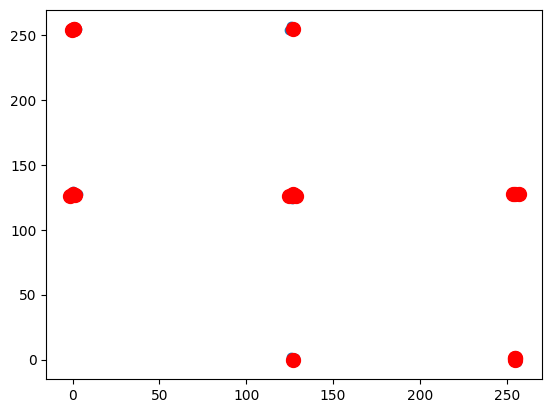

In [3]:
# Read the dataset
dataset = pd.read_pickle('./SMAI-Dataset-problem-4.3/colors.pkl')
# Convert the dataset to a numpy array
dataset = np.array(dataset)

print(dataset.shape)

# Plot the Colours, as a scatter plot, with the colour being the x , y coordinates
plt.scatter(dataset[:, 0], dataset[:, 1])

# Initialize the GMM Class
gmm = GMM(k=20, max_iter=100)
# Initialize the parameters
gmm.initalize_params(dataset)
# Fit the dataset
gmm.fit(dataset)
# Return the parameters
weights, means, variances = gmm.return_params()

# Print the Means
print(means)
print(weights)

# Plot the means
plt.scatter(means[:, 0], means[:, 1], c='r', s=100)


(989, 2)


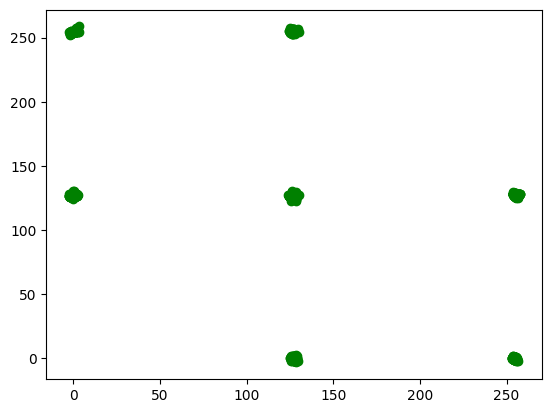

In [4]:
import numpy as np

class Generator:
    def __init__(self, weights, means, variances):
        self.weights = weights
        self.means = means
        self.variances = variances

    def generate_sample_dataset(self, n_samples):
        self.dataset = []
        self.labels = []  # To keep track of the component labels
        
        for i, (mean, variance, weight) in enumerate(zip(self.means, self.variances, self.weights)):
            # Generate the samples
            samples = np.random.multivariate_normal(mean, variance, int(n_samples * weight))
            # ------------------ CHATGPT ------------------------------------------------------------- #
            # Append the samples to the dataset
            self.dataset.extend(samples)
            # Create labels for the component
            component_labels = [i] * len(samples)
            self.labels.extend(component_labels)
            # ------------------ CHATGPT ------------------------------------------------------------- #
        
        # Convert the dataset and labels to numpy arrays
        self.dataset = np.array(self.dataset)
        self.labels = np.array(self.labels)
        
        return self.dataset, self.labels

# Initialize the Generator Class with weights, means, and variances defined earlier
generator = Generator(weights, means, variances)
# Generate the dataset
dataset, labels = generator.generate_sample_dataset(1000)

print(dataset.shape)

# Plot the dataset
plt.scatter(dataset[:, 0], dataset[:, 1], c='g')
